# TITLE: COMPUTER VISION PROJECT - SOLUTION


### AUTHOR: OLABODE JAMES


## Import Libraries

In [1]:
# Standard Python ML Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize as imresize
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

#Classification libraries
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

#Visualization - Visualization Components
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib.pyplot plots data
from matplotlib import cm
sns.set(color_codes=True) # adds a nice background to the graphs
# In order to enable plotting graphs in Jupyter notebook
%matplotlib inline


#ConvNet Libraries - Tensorflow vie Keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Activation, Dropout, Maximum, ZeroPadding2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical

#Tensorflow NeuralNet Management Libraries 
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import PyDrive and Google Drive Libraries

In [2]:
# PyDrive and Google Drive Files and Data handling library
# This is 
import cv2
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab.patches import cv2_imshow

#### PyDrive and GDrive Libraries is being used out of the need to use Link Shareable Files in this project - the author believe this is more scaleable than the standard content mount procedure - need to keep a persistent state.

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Project Deliverables 

### 1. Import the libraries, load dataset, print shape of data, visualize the images in dataset. (5 Marks)

In [4]:
images_link = 'https://drive.google.com/file/d/1sY7XX4bbDhY-zFcTy-_2-Ip7XNX4dtTS/view?usp=sharing' # The shareable link
label_link = 'https://drive.google.com/file/d/1ql40HDKG1_TM5YSPFSv9vkAMrtrTwjJT/view?usp=sharing'

In [5]:
def getShareableID(datalocation):
  fluff, id = datalocation.split('/view')
  fluff1, id1 = fluff.split('d/')
  return id1

In [7]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
#Fetch Image Data
image_id = getShareableID(images_link)
print(image_id) # Verify that you have right id fromt the string manipulation

1sY7XX4bbDhY-zFcTy-_2-Ip7XNX4dtTS


In [9]:
imagedata = drive.CreateFile({'id':image_id}) 
imagedata.GetContentFile('images.npy')  
imagesdata = np.load('images.npy')

In [10]:
#Fetch Label Data
labels_id = getShareableID(label_link)
print(labels_id)

1ql40HDKG1_TM5YSPFSv9vkAMrtrTwjJT


In [11]:
labeldata = drive.CreateFile({'id':labels_id}) 
labeldata.GetContentFile('Labels.csv')  
labelsdata = pd.read_csv('Labels.csv')

In [12]:
#check shape of image and label data
imagesdata.shape, labelsdata.shape

((4750, 128, 128, 3), (4750, 1))

In [13]:
#Visualize the images and Label data
labelsdata.head(10)

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
5,Small-flowered Cranesbill
6,Small-flowered Cranesbill
7,Small-flowered Cranesbill
8,Small-flowered Cranesbill
9,Small-flowered Cranesbill


In [14]:
labelsdata['Label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

In [15]:
labelsdata.nunique()

Label    12
dtype: int64

### We have 12 classes plants for purpose of prediction, in alignment with the Project Problem statement

In [16]:
labelsdata.dtypes

Label    object
dtype: object

Label 
 Plant Name: Small-flowered Cranesbill


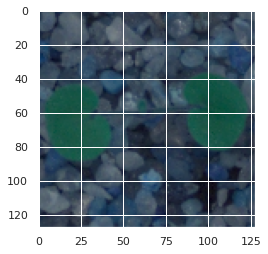

In [17]:
#Visualize random 5 images
i = 0
image = imagesdata[i]
label = labelsdata['Label'][i]
print(f'Label \n Plant Name: {str(label)}')
plt.imshow(image);

Label 
 Plant Name: Shepherds Purse


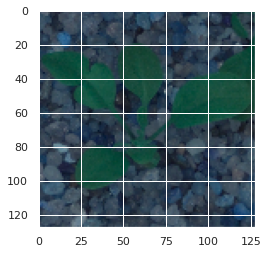

In [18]:
i = 1050
image = imagesdata[i]
label = labelsdata['Label'][i]
print(f'Label \n Plant Name: {str(label)}')
plt.imshow(image);

Label 
 Plant Name: Charlock


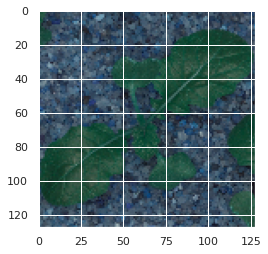

In [19]:
i = 2250
image = imagesdata[i]
label = labelsdata['Label'][i]
print(f'Label \n Plant Name: {str(label)}')
plt.imshow(image);

Label 
 Plant Name: Scentless Mayweed


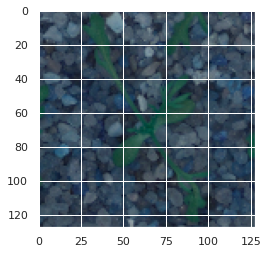

In [20]:
i = 3050
image = imagesdata[i]
label = labelsdata['Label'][i]
print(f'Label \n Plant Name: {str(label)}')
plt.imshow(image);

Label 
 Plant Name: Black-grass


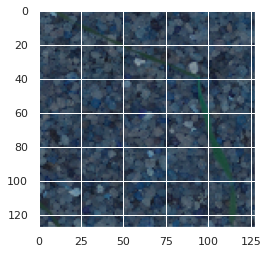

In [21]:
i = 4000
image = imagesdata[i]
label = labelsdata['Label'][i]
print(f'Label \n Plant Name: {str(label)}')
plt.imshow(image);

## Data Preprocessing
Here we carry out - 
a. Normalization.
b. Gaussian Blurring.
c. Visualize data after pre-processing. (15 marks)

#### There is no need to apply resizing as all images are in desireable size - 128 x 128 x 3 channels(RGB)


In [22]:
# Create Function to Display Two images side-by-side
# Display two images
def showTwoImages(firstimg, editedimg, title1="Original", title2 = "Edited"):
    f, axarr = plt.subplots(1,2)
    plt.subplot(128), axarr[0,0].imshow(firstimg), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(140), axarr[0,1].imshow(editedimg), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [23]:
# Set the batch size, number of epochs.
batch_size = 20
num_classes = 12
epochs = 20
#num_predictions = 20

Normalizing image inputs: Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network.

In [24]:
#Step 1 - Input Image Normalization - Choice will be between manual normalizaiton and using Imagegenerator 
datagen = ImageDataGenerator(rescale=1.0/255.0)

pixels = imagesdata
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

# convert from integers to floats
pixels = pixels.astype('float32')

# normalize to the range 0-1
pixels /= 255.0

# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

# prepare an iterators to scale images
#datagen.fit(imagesdata)
#print('Batches Images data=%d' % (len(images_iterator)))

Data Type: uint8
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000


In [25]:
#Visualizing the Normalized data
#Visualize blurring - 
i = 5
image = pixels[i]
original = imagesdata[i]

In [27]:
#showTwoImages(image,original,'original','normalized')

Normalized Image:


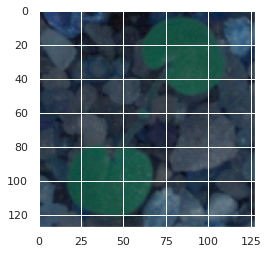

In [28]:
print(f'Normalized Image:')
plt.imshow(image);

Original Image:


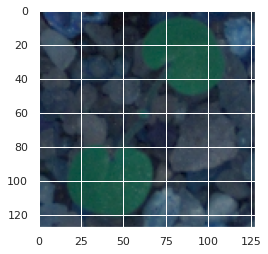

In [29]:
print(f'Original Image:')
plt.imshow(original);

INSIGHT: We are satisfied with the result of the normalization of input image pixels. Moving on ...

In [30]:
#Step 2 - Denoising Images using Guassian Blurring Technique

# Remove noise using GaussianBlur
imagesdata = pixels
no_noise = []
for i in range(len(imagesdata)):
    blur = cv2.GaussianBlur(imagesdata[i], (5, 5), 0)
    no_noise.append(blur)

#Visualize blurring - 
i = 5
image = no_noise[i]
original = imagesdata[i]
#showTwoImages (original, image, 'Original', 'Blurred')

Blurred Image:


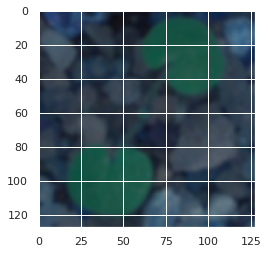

In [31]:
print(f'Blurred Image:')
plt.imshow(image);

Original Image:


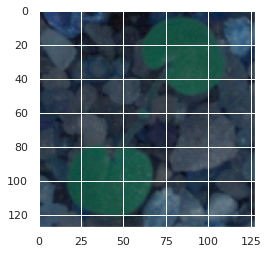

In [32]:
print(f'Original Image:')
plt.imshow(original);

In [34]:
#Step 3 - Image Segmentation and Background, Foreground Separation and Removal

def segmentMophImage(array_of_images):
  #gray = cv2.cvtColor(imagesdata, cv2.COLOR_RGB2GRAY)
  #ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  #Further noise removal
  kernel = np.ones((3, 3), np.uint8)
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

  #sure background area
  sure_bg = cv2.dilate(opening, kernel, iterations=3)

  #Finding sure foreground area
  dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
  ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

  #Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg, sure_fg)

  # Displaying segmented images
  showTwoImages(original, thresh, 'Original', 'Segmented')

#segmentMophImage(imagesdata)

INSIGHT: The step 3 above is for purpose of optimization of the image preprocessing phase.

## Make CNN Compatible Data
a. Convert labels to one-hot-vectors.
b. Print the label for y_train[0].
c. Split the dataset into training, testing, and validation set.
(Hint: First split images and labels into training and testing set with test_size = 0.3. Then further split test data
into test and validation set with test_size = 0.5)
d. Check the shape of data, Reshape data into shapes compatible with Keras models if it’s not already. If it’s
already in the compatible shape, then comment in the notebook that it’s already in compatible shape.(10 marks)

In [35]:
# Convert labels to one hot vectors - Step a above
enc = LabelBinarizer()
labelsdata = enc.fit_transform(labelsdata)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    imagesdata, labelsdata, test_size=0.3, random_state=0)

In [37]:
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=0)

In [38]:
X_train.shape,y_train.shape, X_val.shape, X_test.shape, y_val.shape, y_test.shape

((3325, 128, 128, 3),
 (3325, 12),
 (712, 128, 128, 3),
 (713, 128, 128, 3),
 (712, 12),
 (713, 12))

Printing y_train[0]

Label 
 Plant Name: [1 0 0 0 0 0 0 0 0 0 0 0]


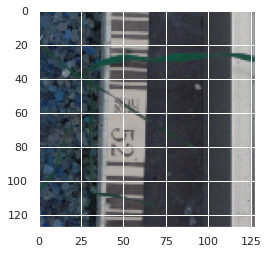

In [40]:
i = 0
image = X_train[i]
label = y_train[i]
print(f'Label \n Plant Name: {str(label)}')
plt.imshow(image);

Label 
 Plant Name: [0 0 0 0 0 0 1 0 0 0 0 0]


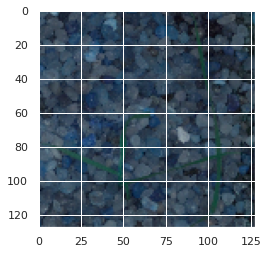

In [41]:
i = 180
image = X_train[i]
label = y_train[i]
print(f'Label \n Plant Name: {str(label)}')
plt.imshow(image);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


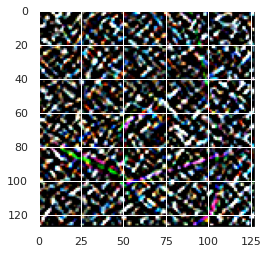

In [42]:
sobel = cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=5)
plt.imshow(sobel)

In [43]:
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(3325, 12)
(713, 12)
(712, 12)


In [44]:
#Checking the training labels
y_train[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [45]:
y_test[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [46]:
y_val[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

DEDUCTION:  We have structured the shape of the input images and labels in formats compatible with the subsequent steps for the building of our Keras model

## Building CNN: (15 Marks)
a. Define layers.
b. Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)

In [47]:
# Define layers for the CNN model
batch_size = None

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape= X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [48]:
# Initiate the Adam optimizer for CNN model
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [49]:
# Define loss funcition for the CNN model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [49]:
#pip install h5py

In [50]:
#here we need to save the best model during training - based on points for possible optimization

checkpoint_filepath = 'best_model.h5'
#cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5
early_stopping = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, patience=20)
model_checkpoint =  ModelCheckpoint(checkpoint_filepath,
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           save_freq=1)

## Fit and evaluate model and print confusion matrix. (10 Marks)

In [55]:
# Set the batch size, number of epochs.
batch_size = 32
num_classes = 12
epochs = 50

In [52]:
#Checking again on input image normalization
print(X_train.min())
print(X_train.max())

0.0
1.0


DEDUCTION: Input image pixels are normalized as desired

In [53]:
X_train = X_train.reshape(X_train.shape[0], 128, 128, 3)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 3)
X_val = X_val.reshape(X_val.shape[0], 128, 128, 3)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(3325, 128, 128, 3)
(713, 128, 128, 3)
(712, 128, 128, 3)


In [56]:
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])

Streaming output truncated to the last 5000 lines.
104/104 [==============================] - 3s 29ms/step - loss: 1.1127 - accuracy: 0.6153 - val_loss: 1.4586 - val_accuracy: 0.4831
Epoch 4/50
104/104 [==============================] - 3s 29ms/step - loss: 1.0557 - accuracy: 0.6487 - val_loss: 1.8781 - val_accuracy: 0.3539
Epoch 5/50
104/104 [==============================] - 3s 29ms/step - loss: 1.0077 - accuracy: 0.6520 - val_loss: 2.3744 - val_accuracy: 0.2542
Epoch 6/50
104/104 [==============================] - 3s 29ms/step - loss: 0.9784 - accuracy: 0.6608 - val_loss: 0.9681 - val_accuracy: 0.7261
Epoch 7/50
104/104 [==============================] - 3s 29ms/step - loss: 0.9273 - accuracy: 0.6827 - val_loss: 2.8958 - val_accuracy: 0.1742
Epoch 8/50
104/104 [==============================] - 3s 29ms/step - loss: 0.9423 - accuracy: 0.6758 - val_loss: 1.3097 - val_accuracy: 0.5674
Epoch 9/50
104/104 [==============================] - 3s 29ms/step - loss: 0.8479 - accuracy: 0.7131 -

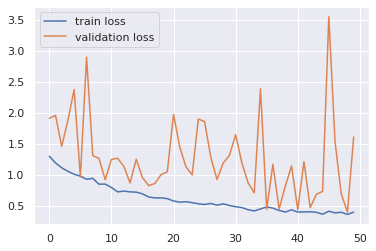

In [57]:
#here we evaluate the model

# plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

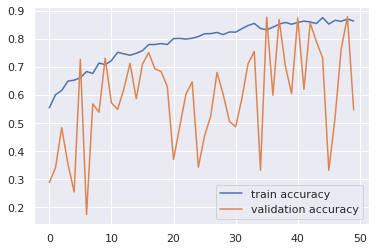

In [58]:
# plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [59]:
# Test accuracy score of model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 14ms/step - loss: 1.5539 - accuracy: 0.5400
Test loss: 1.5539048910140991
Test accuracy: 0.5399719476699829


In [60]:
plantclasses = ['Loose Silky-bent', 'Common Chickweed', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Fat Hen', 'Charlock'
, 'Sugar beet', 'Cleavers', 'Black-grass', 'Shepherds Purse', 'Common wheat', 'Maize']

In [61]:
predictions = np.argmax(model.predict(X_test), axis=-1)

In [62]:
#Following steps necessary for me to understand the flow of data
predictions.shape, y_test.shape

((713,), (713, 12))

In [63]:
predictions[9]

3

In [64]:
test_actual = np.argmax(y_test, axis=-1)

In [65]:
test_actual.shape

(713,)

In [66]:
test_actual[100]

8

In [67]:
print('\nClassification Report\n')
confusion = confusion_matrix(test_actual, predictions)
print('Confusion Matrix\n')
print(confusion)


Classification Report

Confusion Matrix

[[24  0  0  0  0  1 16  0  2  0  0  0]
 [ 0 15  5  0  0  1  0  0 18 17  0  3]
 [ 0  0 28  0  0  6  0  0  6  0  0  0]
 [ 0  0  0 87  0  0  0  0  4  1  0  0]
 [ 4  0  1  0 24  1  3  0  2  0  0  1]
 [ 1  0  0  1  0 33  0  0 26  0  1  0]
 [18  0  0  0  0  0 69  0  3  0  0  0]
 [ 0  0  0  7  0  1  0  8  9 11  0  2]
 [ 0  0  0  2  0  0  1  0 80  0  0  0]
 [ 0  0  0  3  0  0  0  0 10 11  0  0]
 [ 0  0  0 60  0  0  0  0 18  3  3  0]
 [ 1  0  0  1  0  0  0  0 57  0  0  3]]


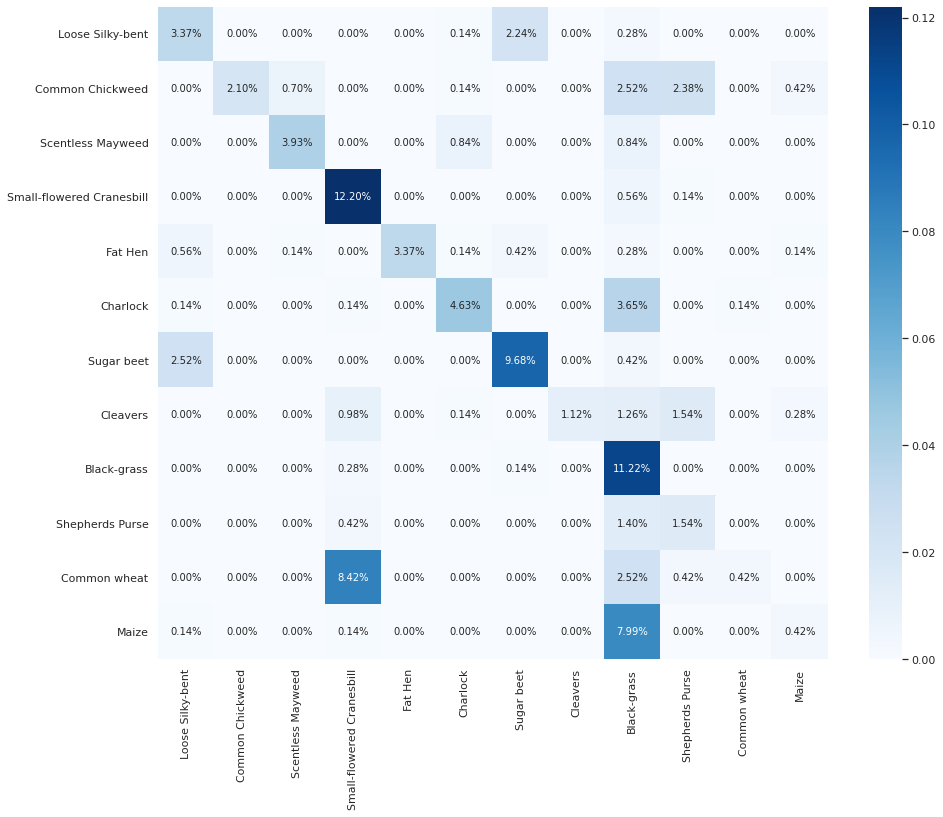

In [68]:
#Using Heatmap, we can create a more graphical confusion matrix
plt.figure(figsize=(15,12))
sns.heatmap(confusion/np.sum(confusion), annot=True,
            fmt='.2%', xticklabels=plantclasses, yticklabels=plantclasses, cmap='Blues')

In [69]:
print(classification_report(test_actual, predictions, target_names=plantclasses))

                           precision    recall  f1-score   support

         Loose Silky-bent       0.50      0.56      0.53        43
         Common Chickweed       1.00      0.25      0.41        59
        Scentless Mayweed       0.82      0.70      0.76        40
Small-flowered Cranesbill       0.54      0.95      0.69        92
                  Fat Hen       1.00      0.67      0.80        36
                 Charlock       0.77      0.53      0.63        62
               Sugar beet       0.78      0.77      0.77        90
                 Cleavers       1.00      0.21      0.35        38
              Black-grass       0.34      0.96      0.50        83
          Shepherds Purse       0.26      0.46      0.33        24
             Common wheat       0.75      0.04      0.07        84
                    Maize       0.33      0.05      0.08        62

                 accuracy                           0.54       713
                macro avg       0.67      0.51      0.49    

## Visualize predictions for 
x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]. (5 Marks)

In [70]:
def fetchplantpredictions(plant_index):
  plt.imshow(X_test[plant_index])
  model_pred = model.predict(X_test[plant_index].reshape(1, 128, 128, 3))
  print("Predicted label:", plantclasses[model_pred.argmax()])
  print("Actual label:", y_test[plant_index])
  print("Softmax Outputs:", model_pred)
  print(model_pred.sum())

Predicted label: Black-grass
Actual label: [0 0 0 0 0 0 0 0 0 1 0 0]
Softmax Outputs: [[1.88237698e-06 1.68561892e-05 3.22926752e-07 1.35981977e-01
  6.75684841e-09 3.02344561e-04 1.12466645e-04 3.11498866e-07
  6.12332523e-01 2.51218319e-01 1.30067956e-05 2.00686773e-05]]
1.0000001


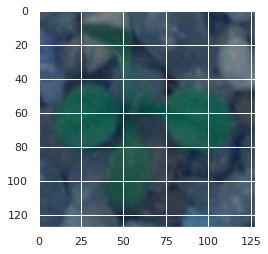

In [71]:
#x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]. (5 Marks)
index = 2
fetchplantpredictions(index)

Predicted label: Sugar beet
Actual label: [0 0 0 0 0 0 1 0 0 0 0 0]
Softmax Outputs: [[1.2163594e-01 5.0889065e-10 3.7991963e-08 4.7453128e-07 6.9510730e-05
  8.0883015e-05 8.7809670e-01 4.6897752e-10 1.1177419e-04 2.9892828e-09
  4.4888043e-06 1.0999842e-07]]
0.9999999


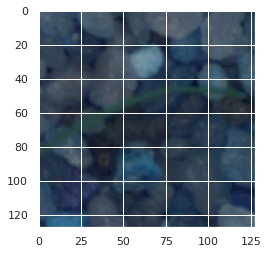

In [72]:
index = 3
fetchplantpredictions(index)

Predicted label: Black-grass
Actual label: [0 0 0 0 0 0 0 0 1 0 0 0]
Softmax Outputs: [[9.9027486e-05 1.4757367e-07 9.2161301e-08 5.1654617e-05 2.6686126e-07
  9.9226952e-07 2.5262642e-03 6.1113609e-10 9.9731112e-01 9.6161993e-06
  1.1640241e-07 6.6686346e-07]]
0.99999994


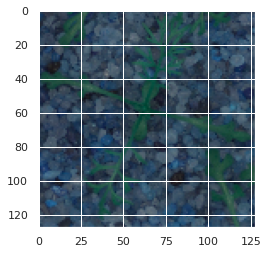

In [73]:
index = 33
fetchplantpredictions(index)

Predicted label: Shepherds Purse
Actual label: [0 0 0 0 0 0 0 1 0 0 0 0]
Softmax Outputs: [[0.00078719 0.04062616 0.00371977 0.14134449 0.00216678 0.02182449
  0.0007169  0.15625226 0.10197771 0.3699298  0.0035893  0.15706517]]
1.0000001


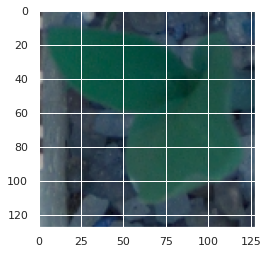

In [74]:
index = 36
fetchplantpredictions(index)

Predicted label: Black-grass
Actual label: [0 0 0 0 0 0 0 0 1 0 0 0]
Softmax Outputs: [[1.3219694e-06 2.8685390e-06 3.6833032e-07 3.2032927e-04 3.5548936e-08
  1.1224162e-06 1.3825086e-04 5.5645502e-09 9.9874347e-01 7.5408269e-04
  7.2393829e-07 3.7406895e-05]]
1.0


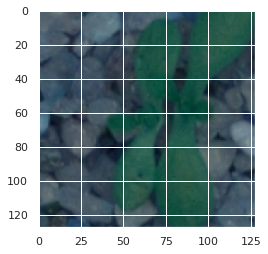

In [75]:
index = 59
fetchplantpredictions(index)

In [76]:
#here we draw conclusion and suggest possible ways for improvement

CONCLUSION:

Higher prediction accuracy is possible especially when the model is built using a high end GPU, although accuracy of 85 - 90% range was achieved, opportunity still exist for achieving a CNN capable of reaching higher predictive power. Making the CNN deeper thus the accuracy here not reflective of the final performance of CNN prediction of plant species.